# PM project

In [6]:
import pm4py
from collections import Counter
import operator
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import warnings
import seaborn as sns
from fitter import Fitter, get_common_distributions 

In [7]:
warnings.filterwarnings('ignore')

In [8]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply("/Users/pietrovolpato/Desktop/UNIPD/PROCESS MINING/Project/ED_Log.xes")

parsing log, completed traces ::   0%|          | 0/11468 [00:00<?, ?it/s]

In [9]:
len(log)

11468

In [10]:
start_act = pm4py.get_start_activities(log)
print(start_act)

{'AUTONOMOUSLY TRIAGE': 8079, 'AMBULANCE TRIAGE': 3378, 'VISIT': 3, 'EMERGENCY SERVICE': 8}


In [11]:
filtered_log = pm4py.filter_start_activities(log, ['AUTONOMOUSLY TRIAGE', 'AMBULANCE TRIAGE']) 
len(filtered_log)

11457

In [12]:
dataframe = pm4py.convert_to_dataframe(filtered_log)
Columns = ["Name", "Triage_columns","Start_Timestamp","End_Timestamp","Resource","Case"]
dataframe.columns = Columns
len(dataframe.Case.unique())

11457

# Point 2.2: Reponse times

In [13]:
times = {'RED':600,  'YELLOW':1200, 'GREEN':3600, 'BLUE':5400, 'WHITE':7200}

In [14]:
def response_time(color, log, parameter):
    long_responses = {} #Dictionary containing as keys misstreated cases, and as values time passed for treatment
    response_times = [] #List containing the response time for each patient
    filtered_log = pm4py.filter_event_attribute_values(log, "triage color", [color], level="case", retain=True)
    for trace in filtered_log:
        start = trace[0]['time:timestamp']
        end = trace[1]['start:timestamp']
        delta = (end - start).total_seconds()
        response_times.append(delta/60)
        if delta<0:
            print('SC')
        if delta > parameter:
            long_responses[trace[0]['case:concept:name']]=delta
        mean = np.round(np.mean(response_times), decimals = 2)
        percentage = np.round(len(long_responses)*100/len(filtered_log), decimals = 2)
    return percentage, mean, response_times

In [15]:
for color in times.keys():
    temp = response_time(color, filtered_log, times[color])
    print(f'{color:<7} has a percentage of misstreated cases of {temp[0]}%, with a mean response time of {temp[1]} minutes')
    color_times = temp[2]

RED     has a percentage of misstreated cases of 20.52%, with a mean response time of 6.72 minutes
YELLOW  has a percentage of misstreated cases of 21.2%, with a mean response time of 14.53 minutes
GREEN   has a percentage of misstreated cases of 21.4%, with a mean response time of 35.51 minutes
BLUE    has a percentage of misstreated cases of 23.12%, with a mean response time of 55.86 minutes
WHITE   has a percentage of misstreated cases of 18.67%, with a mean response time of 65.11 minutes


In [16]:
RED_times = response_time('RED', filtered_log, times[color])[-1]
YELLOW_times = response_time('YELLOW', filtered_log, times[color])[-1]
GREEN_times = response_time('GREEN', filtered_log, times[color])[-1]
BLUE_times = response_time('BLUE', filtered_log, times[color])[-1]
WHITE_times = response_time('WHITE', filtered_log, times[color])[-1]

In [65]:
max(RED_times)

60.35

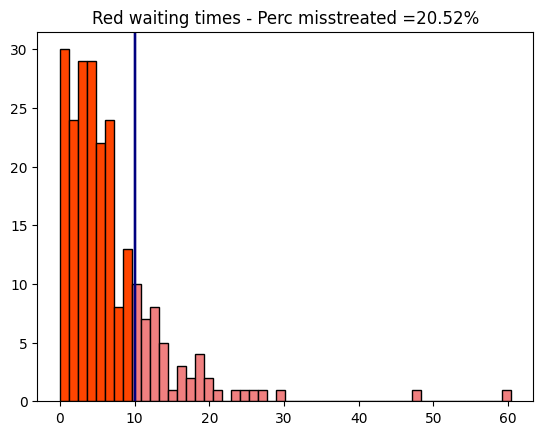

In [66]:
color = 'RED'
temp = response_time(color, filtered_log, times[color])
n, bins, patches = plt.hist(RED_times, 50)

for c, p in zip(bins, patches):
    if c >= 0 and c < 9.5:
        plt.setp(p, 'facecolor', 'orangered', edgecolor = 'black')
        plt.axvline(10, color = 'navy')
    else :
        plt.setp(p, 'facecolor', 'lightcoral', edgecolor = 'black')
plt.title('Red waiting times - Perc misstreated ='+str(temp[0])+'%')
plt.show()

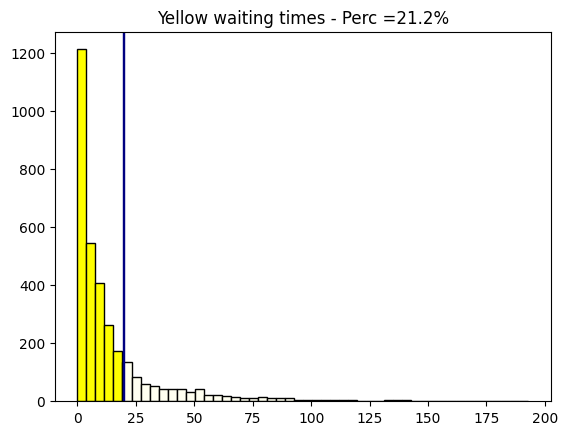

In [67]:
color = 'YELLOW'
temp = response_time(color, filtered_log, times[color])
n, bins, patches = plt.hist(YELLOW_times, 50)

for c, p in zip(bins, patches):
    if c >= 0 and c < 18:
        plt.setp(p, 'facecolor', 'yellow', edgecolor = 'black')
        plt.axvline(20, color = 'navy')
    else :
        plt.setp(p, 'facecolor', 'ivory', edgecolor = 'black')
plt.title('Yellow waiting times - Perc ='+str(temp[0])+'%')
plt.show()

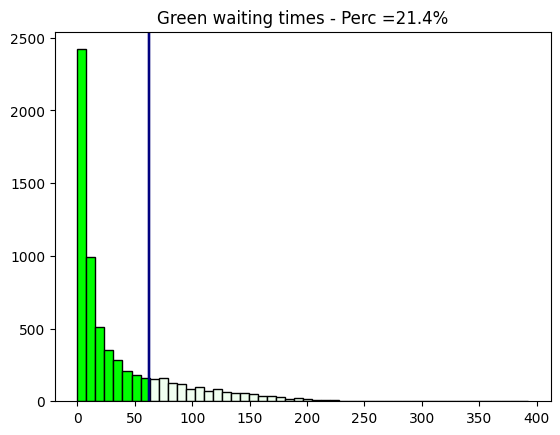

In [68]:
color = 'GREEN'
temp = response_time(color, filtered_log, times[color])
n, bins, patches = plt.hist(GREEN_times, 50)

for c, p in zip(bins, patches):
    if c >= 0 and c < 60:
        plt.setp(p, 'facecolor', 'lime', edgecolor = 'black')
        plt.axvline(62, color = 'navy')
    else :
        plt.setp(p, 'facecolor', 'honeydew', edgecolor = 'black')
plt.title('Green waiting times - Perc ='+str(temp[0])+'%')
plt.show()

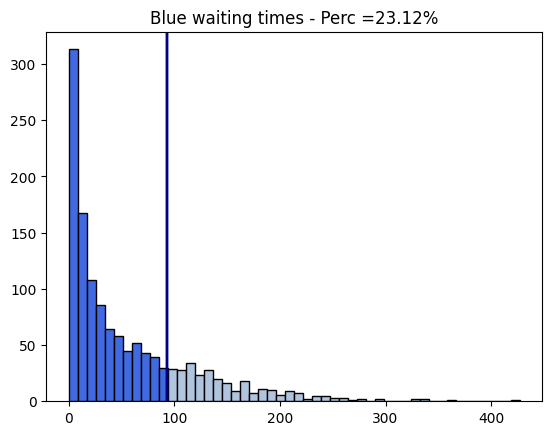

In [69]:
color = 'BLUE'
temp = response_time(color, filtered_log, times[color])
n, bins, patches = plt.hist(BLUE_times, 50)

for c, p in zip(bins, patches):
    if c >= 0 and c < 90:
        plt.setp(p, 'facecolor', 'royalblue', edgecolor = 'black')
        plt.axvline(93, color = 'navy')
    else :
        plt.setp(p, 'facecolor', 'lightsteelblue', edgecolor = 'black')
plt.title('Blue waiting times - Perc ='+str(temp[0])+'%')
plt.show()

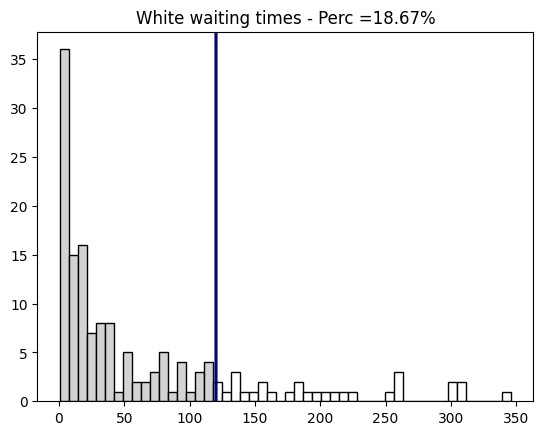

In [70]:
color = 'WHITE'
temp = response_time(color, filtered_log, times[color])
n, bins, patches = plt.hist(WHITE_times, 50)

for c, p in zip(bins, patches):
    if c >= 0 and c < 118:
        plt.setp(p, 'facecolor', 'lightgray', edgecolor = 'black')
        plt.axvline(120, color = 'navy')
    else :
        plt.setp(p, 'facecolor', 'white', edgecolor = 'black')
plt.title('White waiting times - Perc ='+str(temp[0])+'%')
plt.show()

# Roles re-discovery

In [71]:
roles = pm4py.discover_organizational_roles(filtered_log)
roles

[Activities: ['AMBULANCE TRIAGE'] Originators importance {'ambulance': 3378},
 Activities: ['ANGIO REPORT'] Originators importance {'R104': 6, 'R73': 3, 'R85': 4, 'R75': 2, 'R97': 4, 'R110': 5, 'R103': 5, 'R99': 3, 'R107': 6, 'R78': 5, 'R96': 3, 'R77': 8, 'R87': 5, 'R91': 3, 'R100': 5, 'R84': 4, 'R83': 6, 'R98': 3, 'R95': 3, 'R92': 2, 'R86': 5, 'R105': 2, 'R80': 2, 'R82': 2, 'R88': 6, 'R79': 2, 'R81': 5, 'R72': 1, 'R101': 6, 'R74': 3, 'R94': 2, 'R76': 1, 'R90': 1, 'R109': 2, 'R93': 2, 'R89': 2},
 Activities: ['ANGIO', 'TC', 'X-RAY'] Originators importance {'R60': 232, 'R70': 244, 'R53': 242, 'R63': 277, 'R54': 238, 'R56': 216, 'R61': 236, 'R50': 237, 'R51': 246, 'R65': 221, 'R55': 248, 'R64': 226, 'R69': 230, 'R46': 218, 'R66': 201, 'R49': 200, 'R47': 235, 'R62': 230, 'R58': 222, 'R71': 203, 'R52': 257, 'R67': 241, 'R59': 197, 'R45': 216, 'R48': 235, 'R57': 200, 'R68': 235},
 Activities: ['AUTONOMOUSLY TRIAGE'] Originators importance {'autonomous': 8079},
 Activities: ['BLOOD SAMPLING'

In [72]:
roles = pm4py.discover_organizational_roles(filtered_log)
for i in range (len(roles)):
    print(roles[i].activities, ':',len(roles[i].originator_importance.values()))

['AMBULANCE TRIAGE'] : 1
['ANGIO REPORT'] : 36
['ANGIO', 'TC', 'X-RAY'] : 27
['AUTONOMOUSLY TRIAGE'] : 1
['BLOOD SAMPLING', 'EMERGENCY SERVICE'] : 30
['CONSULTATION'] : 34
['DISCHARGE', 'VISIT'] : 15
['ECHO', 'TC REPORT', 'X-RAY REPORT'] : 39
['LABORATORY'] : 96
['MRI'] : 5
['MRI REPORT'] : 5
['OBSERVATION'] : 12


### MRI and MRI-REPORT

Given the frequency scarceness of performing those actions, we can group the resources performing those activities under a different role

In [73]:
MRI = list(roles[-3].originator_importance.keys())
MRI_REPORT = list(roles[-2].originator_importance.keys())
print(MRI, MRI_REPORT)

['R57', 'R71', 'R55', 'R70', 'R68'] ['R104', 'R87', 'R95', 'R91', 'R79']


In [74]:
attività_MRI = []
attività_MRI_REPORT = []
for trace in filtered_log:
    for event in trace:
        if event['org:resource'] in MRI and event['concept:name'] not in attività_MRI and event['concept:name']!='MRI':
            attività_MRI.append( event['concept:name'])
        if event['org:resource'] in MRI_REPORT and event['concept:name'] not in attività_MRI_REPORT and event['concept:name']!='MRI REPORT':
            attività_MRI_REPORT.append(event['concept:name'])
ANGIO_REPORT = list(roles[1].originator_importance.keys())
attività_ANGIO_REPORT = []
for trace in filtered_log:
    for event in trace:
        if event['org:resource'] in ANGIO_REPORT and event['concept:name'] not in attività_ANGIO_REPORT:
            attività_ANGIO_REPORT.append(event['concept:name'])
attività_ANGIO_REPORT.remove('ANGIO REPORT')
print('People performing MRI, also perform {}'.format(", ".join(attività_MRI)))
print('People performing MRI_REPORT, also perform {}'.format(", ".join(attività_MRI_REPORT)))
print('People performing ANGIO-REPORT, also perform {}'.format(", ".join(attività_ANGIO_REPORT)))

People performing MRI, also perform X-RAY, ANGIO, TC
People performing MRI_REPORT, also perform X-RAY REPORT, TC REPORT, ANGIO REPORT, ECHO
People performing ANGIO-REPORT, also perform X-RAY REPORT, TC REPORT, ECHO, MRI REPORT


### ANGIO-REPORT

In [22]:
print(ANGIO_REPORT)

['R104', 'R73', 'R85', 'R75', 'R97', 'R110', 'R103', 'R99', 'R107', 'R78', 'R96', 'R77', 'R87', 'R91', 'R100', 'R84', 'R83', 'R98', 'R95', 'R92', 'R86', 'R105', 'R80', 'R82', 'R88', 'R79', 'R81', 'R72', 'R101', 'R74', 'R94', 'R76', 'R90', 'R109', 'R93', 'R89']


In [23]:
ANGIO_REPORT = list(roles[1].originator_importance.keys())
attività_ANGIO_REPORT = []
for trace in filtered_log:
    for event in trace:
        if event['org:resource'] in ANGIO_REPORT and event['concept:name'] not in attività_ANGIO_REPORT:
            attività_ANGIO_REPORT.append(event['concept:name'])
attività_ANGIO_REPORT.remove('ANGIO REPORT')
print('People performing ANGIO-REPORT, also perform {}'.format(",".join(attività_ANGIO_REPORT)))

People performing ANGIO-REPORT, also perform X-RAY REPORT,TC REPORT,ECHO,MRI REPORT


### Merging

In [24]:
TC_XRAY_ANGIO_TC = roles[2].originator_importance
ECHO_TC_REP_XRAY_REP = roles[-5].originator_importance
ANGIO_REPORT = roles[1].originator_importance
MRI = roles[-3].originator_importance
MRI_REPORT = roles[-2].originator_importance
Radio = [TC_XRAY_ANGIO_TC, MRI]
Report = [ECHO_TC_REP_XRAY_REP, ANGIO_REPORT, MRI_REPORT]

In [25]:
Radio_resources = sum(
    (Counter(dict(x)) for x in Radio),
    Counter())

In [26]:
Report_resources = sum(
    (Counter(dict(x)) for x in Report),
    Counter())

In [27]:
print(len(Radio_resources.values()))
print(len(Report_resources.values()))

27
39


In [28]:
print(len(TC_XRAY_ANGIO_TC))
len((ECHO_TC_REP_XRAY_REP))

27


39

In [29]:
Ruoli = {'AMBULANCE TRIAGE':'Ambulance', 'ANGIO':'Radio_operator','TC':'Radio_operator','X-RAY':'Radio_operator','MRI':'Radio_operator',
        'ANGIO REPORT':'Radio_reporter', 'ECHO':'Radio_reporter', 'TC REPORT':'Radio_reporter', 'MRI REPORT':'Radio_reporter', 'X-RAY REPORT':'Radio_reporter',
        'AUTONOMOUSLY TRIAGE':'Auto','BLOOD SAMPLING':'Nurse','EMERGENCY SERVICE':'Nurse','VISIT':'Doctor',
        'DISCHARGE':'Doctor','CONSULTATION':'Operator_1','OBSERVATION':'Bed','LABORATORY':'Operator_2'}

In [30]:
for i in range(len(dataframe)):
    dataframe.loc[i,'Role'] = Ruoli[dataframe.iloc[i,0]]

In [31]:
dataframe.head()

,Name,Triage_columns,Start_Timestamp,End_Timestamp,Resource,Case,Role
0,AUTONOMOUSLY TRIAGE,BLUE,2017-01-01 00:17:51,2017-01-01 00:17:51,autonomous,1,Auto
1,VISIT,BLUE,2017-01-01 01:18:35,2017-01-01 01:26:38,R5,1,Doctor
2,DISCHARGE,BLUE,2017-01-01 01:27:37,2017-01-01 01:27:39,R11,1,Doctor
3,AUTONOMOUSLY TRIAGE,GREEN,2017-01-01 00:40:21,2017-01-01 00:40:21,autonomous,2,Auto
4,VISIT,GREEN,2017-01-01 00:57:04,2017-01-01 00:59:18,R11,2,Doctor


In [32]:
new_roles = {x:[] for x in list(set(Ruoli.values()))}
for i in range(len(dataframe)):
    if dataframe.iloc[i,-3] not in new_roles[dataframe.iloc[i,-1]]:
        new_roles[dataframe.iloc[i,-1]].append(dataframe.iloc[i,-3])



In [33]:
new_roles = {k:len(v) for k,v in new_roles.items()}
new_roles

{'Auto': 1,
 'Radio_reporter': 39,
 'Operator_1': 34,
 'Bed': 12,
 'Nurse': 30,
 'Doctor': 15,
 'Radio_operator': 27,
 'Ambulance': 1,
 'Operator_2': 96}

In [34]:
for i in range(len(roles)):
    print(roles[i].activities, len(roles[i].originator_importance.values()))

['AMBULANCE TRIAGE'] 1
['ANGIO REPORT'] 36
['ANGIO', 'TC', 'X-RAY'] 27
['AUTONOMOUSLY TRIAGE'] 1
['BLOOD SAMPLING', 'EMERGENCY SERVICE'] 30
['CONSULTATION'] 34
['DISCHARGE', 'VISIT'] 15
['ECHO', 'TC REPORT', 'X-RAY REPORT'] 39
['LABORATORY'] 96
['MRI'] 5
['MRI REPORT'] 5
['OBSERVATION'] 12


# Distribution

In [75]:
values = {k:[] for k in list(dataframe.Name.unique())}
for trace in log:
    for event in trace:
        start = event['start:timestamp']
        end = event['time:timestamp']
        delta = end - start
        delta = np.round((delta.total_seconds())/60, decimals = 2)
        values[event['concept:name']].append(delta)

In [76]:
print(max(values['AUTONOMOUSLY TRIAGE']))
print(max(values['AMBULANCE TRIAGE']))

0.0
0.0


In [77]:
del values['AUTONOMOUSLY TRIAGE']
del values['AMBULANCE TRIAGE']
activities = list(values.keys())

In [38]:
activities

['VISIT',
 'DISCHARGE',
 'EMERGENCY SERVICE',
 'LABORATORY',
 'CONSULTATION',
 'X-RAY',
 'X-RAY REPORT',
 'TC',
 'TC REPORT',
 'BLOOD SAMPLING',
 'ANGIO',
 'ANGIO REPORT',
 'OBSERVATION',
 'ECHO',
 'MRI',
 'MRI REPORT']

### Negative time for certain activities

In [39]:
len(filtered_log)

11457

In [40]:
i = 0
for trace in filtered_log:
    for event in trace:
        start = event['start:timestamp']
        end = event['time:timestamp']
        delta = (end - start).total_seconds()
        if delta < 0 and i<5:
            print((event))
        if delta < 0:
            i+=1
print('There are a total of {} activities with negative delta timestamps'.format(i))

{'concept:name': 'OBSERVATION', 'triage color': 'GREEN', 'start:timestamp': datetime.datetime(2017, 1, 14, 11, 51, 16), 'time:timestamp': datetime.datetime(2017, 1, 14, 10, 11, 47), 'org:resource': 'bed11', 'case:concept:name': '1352'}
{'concept:name': 'OBSERVATION', 'triage color': 'GREEN', 'start:timestamp': datetime.datetime(2017, 2, 27, 9, 55, 54), 'time:timestamp': datetime.datetime(2017, 2, 27, 5, 50, 4), 'org:resource': 'bed7', 'case:concept:name': '6384'}
{'concept:name': 'OBSERVATION', 'triage color': 'YELLOW', 'start:timestamp': datetime.datetime(2017, 3, 24, 0, 11, 54), 'time:timestamp': datetime.datetime(2017, 3, 23, 22, 38, 18), 'org:resource': 'bed10', 'case:concept:name': '9508'}
There are a total of 3 activities with negative delta timestamps


### Total activities witht time eqaul to 0

In [41]:
i = 0
for trace in filtered_log:
    for event in trace:
        start = event['start:timestamp']
        end = event['time:timestamp']
        if start == end:
            i+=1
print('There are a total of {} activities with timestamps equal to 0'.format(i-11457))

There are a total of 2220 activities with timestamps equal to 0


### Time execution

In [42]:
import pm4py.statistics.sojourn_time.log.get as soj_time_get
soj_time = soj_time_get.apply(log, parameters={soj_time_get.Parameters.TIMESTAMP_KEY: "time:timestamp",
                                               soj_time_get.Parameters.START_TIMESTAMP_KEY: "start:timestamp"})
soj_time = {k:round(v/60,2) for k,v in soj_time.items()}
print(soj_time)

{'AUTONOMOUSLY TRIAGE': 0.0, 'VISIT': 4.72, 'DISCHARGE': 1.8, 'EMERGENCY SERVICE': 5.7, 'LABORATORY': 84.21, 'CONSULTATION': 36.12, 'X-RAY': 21.54, 'X-RAY REPORT': 0.87, 'AMBULANCE TRIAGE': 0.0, 'TC': 18.51, 'TC REPORT': 5.6, 'BLOOD SAMPLING': 25.77, 'ANGIO': 71.31, 'ANGIO REPORT': 7.91, 'OBSERVATION': 480.12, 'ECHO': 17.34, 'MRI': 99.18, 'MRI REPORT': 0.8}


When calculating the time each activity takes, we don't consider activities with delta = 0

In [100]:
times_no_zero = {x:[] for x in list(dataframe.Name.unique())}
for trace in filtered_log:
    for event in trace:
        start = event['start:timestamp']
        end = event['time:timestamp']
        delta = end - start
        delta = delta.total_seconds()
        if delta > 0:
            times_no_zero[event['concept:name']].append(delta/60)

In [102]:
np.var(times_no_zero['X-RAY'])

641.9220487199324

In [25]:
counter = 0
for trace in filtered_log:
    for event in trace:
        start = event['start:timestamp']
        end = event['time:timestamp']
        delta = end - start
        delta = delta.total_seconds()
        if delta <= 0 and event['concept:name']=='EMERGENCY SERVICE':
            counter += 1
counter

1845

In [114]:
massimo = 10000000000
for trace in filtered_log:
    for event in trace:
        start = event['start:timestamp']
        end = event['time:timestamp']
        delta = end - start
        delta = delta.total_seconds()
        if delta ==1 and event['concept:name']=='TC':
            massimo = delta
            print(event)
massimo

{'concept:name': 'TC', 'triage color': 'YELLOW', 'start:timestamp': datetime.datetime(2017, 1, 12, 17, 35, 59), 'time:timestamp': datetime.datetime(2017, 1, 12, 17, 36), 'org:resource': 'R51', 'case:concept:name': '1187'}


1.0

In [46]:
end - start

datetime.timedelta(seconds=5)

23.998611111111114

In [26]:
del times_no_zero['AUTONOMOUSLY TRIAGE']
del times_no_zero['AMBULANCE TRIAGE']
times_no_zero_min = {k:(np.mean(v)/60).round(2) for k,v in times_no_zero.items()}

In [27]:
for k in times_no_zero.keys():
    temp = (-soj_time[k]+times_no_zero_min[k]).round(2)
    if temp>0:
        print(f'{k} has a difference of {temp} minutes without zeros')

NameError: name 'soj_time' is not defined

## Simulation variables

In [36]:
np.mean(times_no_zero['EMERGENCY SERVICE'])

7.810708278826388

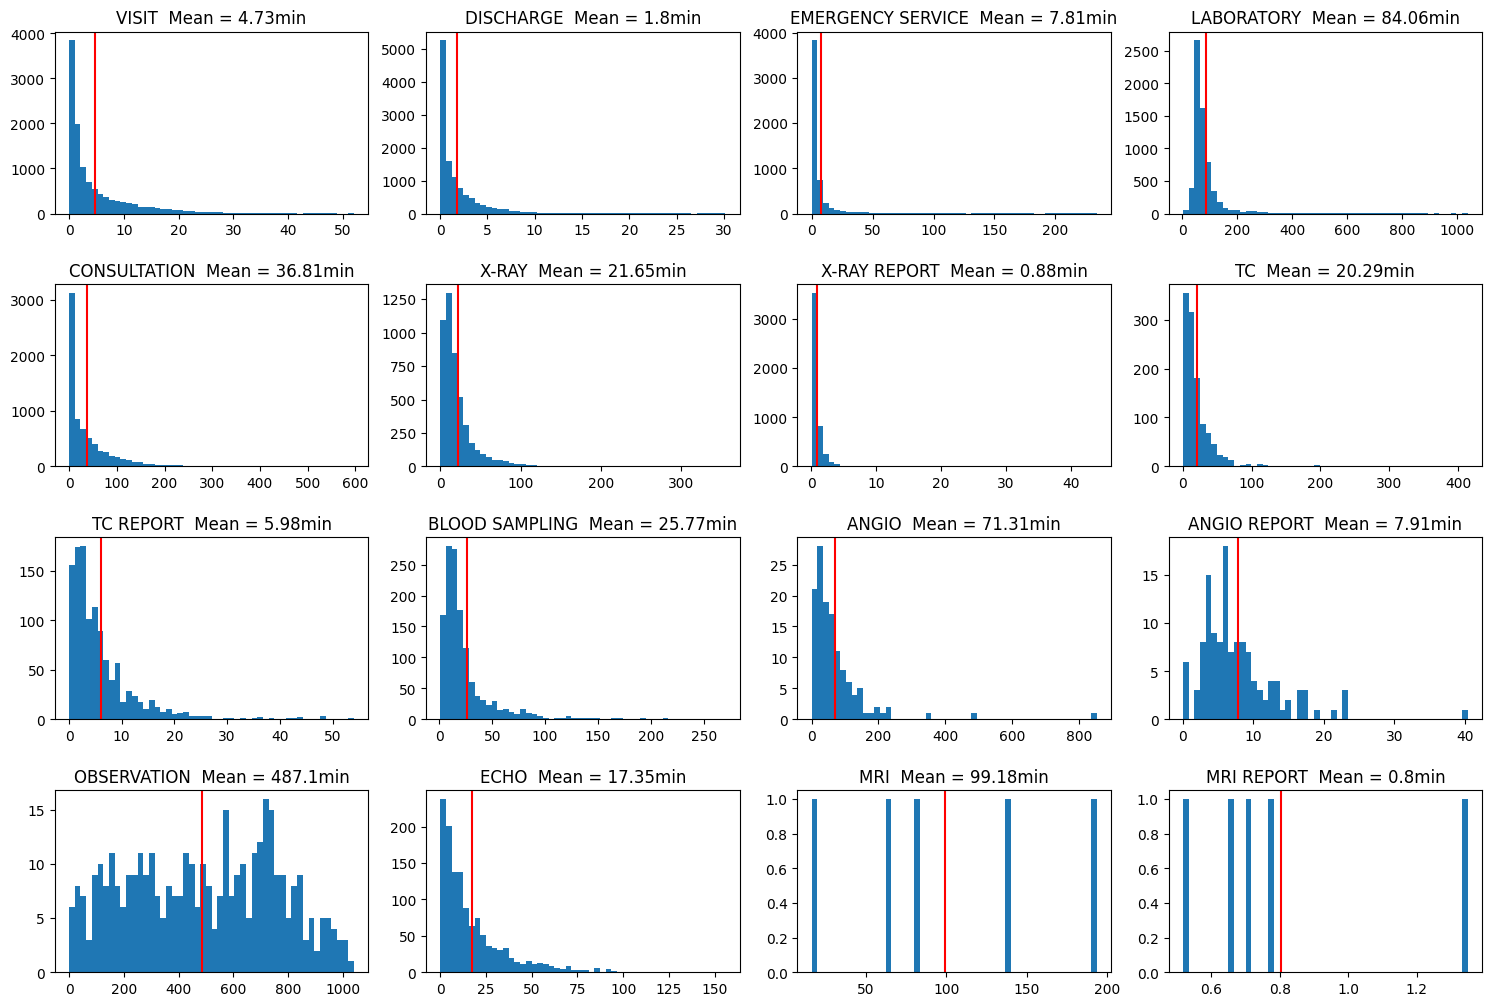

In [31]:
figure, axis = plt.subplots(4, 4, figsize = (15,10))
figure.tight_layout(h_pad=3)
z = 0
for i in range(4):
    for j in range(4):
        activity = activities[z]
        axis[i,j].set_title(str(activity)+'  Mean = '+str(np.mean(times_no_zero[activity]).round(2)) +'min')
        axis[i,j].hist(times_no_zero[activity], bins=50)
        axis[i,j].axvline(np.mean(times_no_zero[activity]), c='red', label='avg')
        z += 1

In [ ]:
times

### Angio

In [48]:
from fitter import Fitter, get_common_distributions
temp_var = 'ANGIO'
f = Fitter(times_no_zero['ANGIO'],
           distributions=['lognorm',"expon",
                          "norm","uniform"])
f.fit()
print(f.get_best(method = 'sumsquare_error'))
temp_2 = times_no_zero[temp_var]
print(f'Angio mean:{np.mean(temp_2).round(2)}') 
print(f'Angio Variance:{np.var(temp_2).round(2)}')

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 50.01it/s]

{'lognorm': {'s': 0.9204248393283003, 'loc': -5.742728574505327, 'scale': 50.11934104859945}}
Angio mean:71.31
Angio Variance:9392.07


### Angio report

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s]


{'lognorm': {'s': 0.46155444072919694, 'loc': -3.154601034709139, 'scale': 9.927921705701465}}
Angio - report mean:7.91 - Variance:32.17


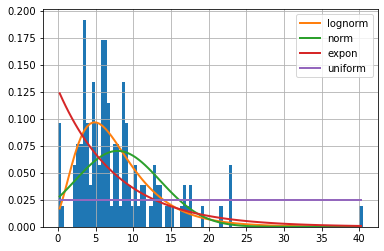

In [49]:
temp_var = 'ANGIO REPORT'
f = Fitter(times_no_zero[temp_var],
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
print(f.get_best(method = 'sumsquare_error'))
temp_2 = times_no_zero[temp_var]
print(f'Angio - report mean:{np.mean(temp_2).round(2)} - Variance:{np.var(temp_2).round(2)}')

### Blood sampling

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 18.33it/s]


['lognorm']
Blood sampling mean:25.77
Variance:973.76


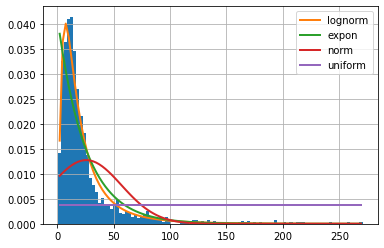

In [50]:
from fitter import Fitter, get_common_distributions
temp_var = 'BLOOD SAMPLING'
f = Fitter(times_no_zero[temp_var],
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
print(list(f.get_best(method = 'sumsquare_error').keys()))
temp_2 = times_no_zero[temp_var]
print(f'Blood sampling mean:{np.mean(temp_2).round(2)}')
print(f'Variance:{np.var(temp_2).round(2)}')

### Laboratory

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 16.33it/s]


{'norm': {'loc': 84.22285115303984, 'scale': 76.93811736181064}}
Laboratory mean:84.22 - sd:76.94


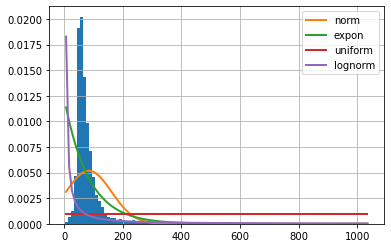

In [51]:
temp_var = 'LABORATORY'
f = Fitter(times_no_zero[temp_var],
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
print(f.get_best(method = 'sumsquare_error'))
temp_2 = times_no_zero[temp_var]
print(f'Laboratory mean:{np.mean(temp_2).round(2)} - sd:{np.std(temp_2).round(2)}')

In [52]:
print(np.var(temp_2))

5919.473903179749


### MRI and MRI Report

In [53]:
temp_var = 'MRI'
temp_2 = times_no_zero[temp_var]
print(f'{temp_var} - Lower Bound: {round(min(temp_2),2)} - Upper bound: {(round(max(temp_2),2))}')
temp_var = 'MRI REPORT'
temp_2 = times_no_zero[temp_var]
print(f'{temp_var} - Lower Bound: {round(min(temp_2),2)} - Upper bound: {(round(max(temp_2),2))}')

MRI - Lower Bound: 16.33 - Upper bound: 193.52
MRI REPORT - Lower Bound: 0.52 - Upper bound: 1.35


### Observation

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 22.08it/s]


{'uniform': {'loc': 0.18333333333333332, 'scale': 1041.5}}
Observation - minimum: 0.18 - max: 1041.68


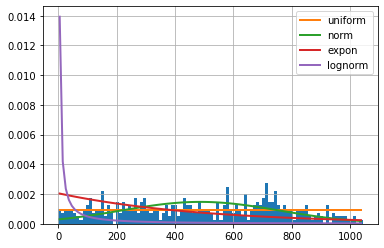

In [54]:
temp_var = 'OBSERVATION'
f = Fitter(times_no_zero[temp_var],
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
print(f.get_best(method = 'sumsquare_error'))
temp_2 = times_no_zero[temp_var]
print(f'Observation - minimum: {round(min(temp_2),2)} - max: {round(max(temp_2),2)}')

### X-Ray

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 29.79it/s]


{'expon': {'loc': 0.016666666666666666, 'scale': 21.567132818479095}}
Mean: 21.58


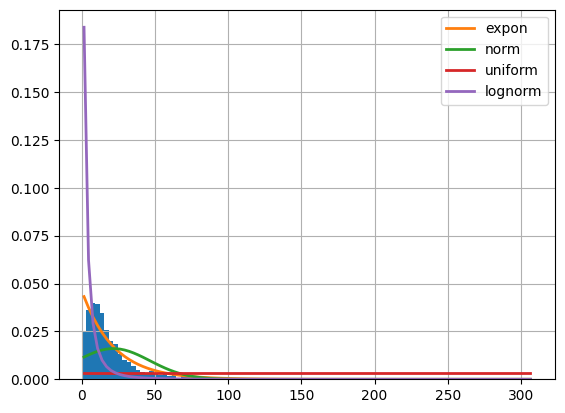

In [97]:
temp_var = 'X-RAY'
f = Fitter(times_no_zero[temp_var],
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
print(f.get_best(method = 'sumsquare_error'))
temp_2 = times_no_zero[temp_var]
print(f'Mean: {np.round(np.mean(temp_2), decimals=2)}')

In [95]:
np.var(times_no_zero['X-RAY'])

618.8785795271307

In [92]:
times_no_zero['X-RAY'].pop(times_no_zero['X-RAY'].index(max(times_no_zero['X-RAY'])))

354.85

In [98]:
max(times_no_zero['X-RAY'])

308.0

### X-Ray report

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 42.66it/s]


X-Ray report mean:0.88 - Variance:4.2


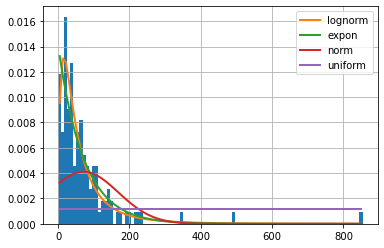

In [56]:
temp_var = 'X-RAY REPORT'
f = Fitter(times_no_zero['ANGIO'],
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')
temp_2 = times_no_zero[temp_var]
print(f'X-Ray report mean:{np.mean(temp_2).round(2)} - Variance:{np.var(temp_2).round(2)}')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 12.72it/s]


{'lognorm': {'s': 0.9509851510291862,
  'loc': -35.69255252035748,
  'scale': 480.6853112262705}}

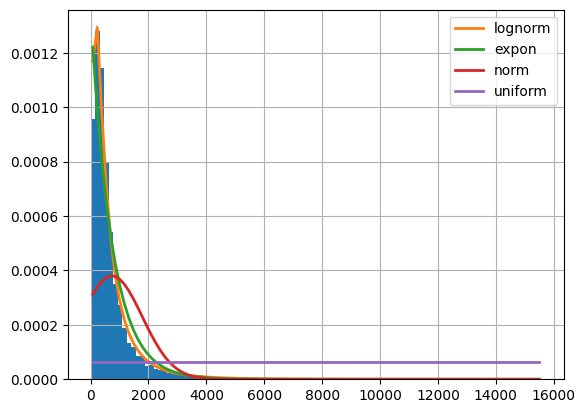

In [21]:
f = Fitter(arrival_times,
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')
#temp_2 = times_no_zero[temp_var]
#print(f'X-Ray report mean:{np.mean(temp_2).round(2)} - Variance:{np.var(temp_2).round(2)}')

In [22]:
np.var(arrival_times)

1099969.9216340673

In [57]:
pm4py.get_case_arrival_average(filtered_log)/60

12.280001745810056

In [18]:
arrival_times = []
for i in range (len(filtered_log)-1):
    start = filtered_log[i][0]['start:timestamp']
    end = filtered_log[i+1][0]['start:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    if delta < 0:
        print(log[i][0])
    arrival_times.append(delta)
    

In [19]:
massimo = 1000000
for i in range (len(filtered_log)-1):
    start = filtered_log[i][0]['start:timestamp']
    end = filtered_log[i+1][-1]['time:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    if delta==1:
        print(filtered_log[i])
massimo    

1000000

In [17]:
plt.hist(arrival_times, bins = 100)
plt.axvline(np.mean(arrival_times), color = 'red')
plt.title('Case arrival average - Mean:'+str((np.mean(arrival_times)/60).round(2))+' Minutes')
plt.show

NameError: name 'arrival_times' is not defined

In [154]:
print(np.var(arrival_times))

1099969.9216340673


### Arrival times divided by hour

In [60]:
import pytz
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
utc = pytz.UTC
from_23_7 = []
from_8_22 = []
for i in range (len(filtered_log)-1):
    start = filtered_log[i][0]['start:timestamp']
    end = filtered_log[i+1][0]['start:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    date = start.replace(tzinfo = utc)
    time = date.time().hour
    if time < 8 or time > 23:
        from_23_7.append(delta)
    else:
        from_8_22.append(delta)


## From 23 to 7

<function matplotlib.pyplot.show(close=None, block=None)>

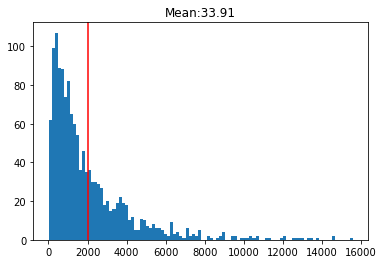

In [61]:
plt.hist(from_23_7, bins = 100)
plt.title('Mean:'+str((np.mean(from_23_7)/60).round(2)))
plt.axvline(np.mean(from_23_7), color = 'red')
plt.show

## From 8 to 22

<function matplotlib.pyplot.show(close=None, block=None)>

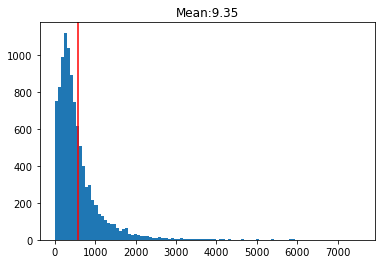

In [62]:
plt.hist(from_8_22, bins = 100)
plt.title('Mean:'+str((np.mean(from_8_22)/60).round(2)))
plt.axvline(np.mean(from_8_22), color = 'red')
plt.show

Fitting 4 distributions: 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]


{'expon': {'loc': 0.0, 'scale': 561.1349851337958}}

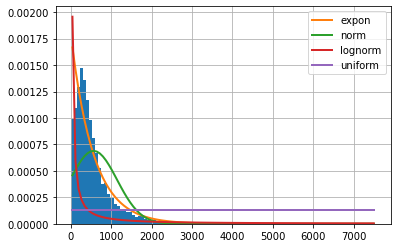

In [63]:
temp_var = 'X-RAY REPORT'
f = Fitter(from_8_22,
           distributions=['lognorm',
                          "expon",
                          "norm",
                          "uniform"
                         ])
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

In [64]:
rework = pm4py.get_rework_cases_per_activity(filtered_log)

In [65]:
rework

{'EMERGENCY SERVICE': 1365,
 'LABORATORY': 1311,
 'CONSULTATION': 936,
 'X-RAY': 147,
 'X-RAY REPORT': 171,
 'TC': 32,
 'TC REPORT': 33,
 'ECHO': 10}

In [66]:
from pm4py.statistics.rework.cases.log import get as cases_rework_get
dictio = cases_rework_get.apply(filtered_log)

In [67]:
dictio

{'1': {'number_activities': 3, 'rework': 0},
 '2': {'number_activities': 7, 'rework': 2},
 '3': {'number_activities': 4, 'rework': 0},
 '5': {'number_activities': 7, 'rework': 0},
 '8': {'number_activities': 7, 'rework': 0},
 '9': {'number_activities': 4, 'rework': 0},
 '11': {'number_activities': 6, 'rework': 0},
 '12': {'number_activities': 7, 'rework': 0},
 '13': {'number_activities': 6, 'rework': 1},
 '14': {'number_activities': 3, 'rework': 0},
 '15': {'number_activities': 5, 'rework': 1},
 '16': {'number_activities': 3, 'rework': 0},
 '17': {'number_activities': 3, 'rework': 0},
 '18': {'number_activities': 5, 'rework': 0},
 '20': {'number_activities': 4, 'rework': 0},
 '26': {'number_activities': 4, 'rework': 0},
 '27': {'number_activities': 9, 'rework': 2},
 '28': {'number_activities': 4, 'rework': 0},
 '29': {'number_activities': 4, 'rework': 0},
 '30': {'number_activities': 5, 'rework': 0},
 '31': {'number_activities': 6, 'rework': 0},
 '38': {'number_activities': 5, 'rework'

In [68]:
dictio = {k:v for k,v in dictio.items() if v['rework']>0}

In [69]:
len(dictio)

3008

In [70]:
activities = dataframe['Name'].unique()
perc = {z:[] for z in activities}
for z in activities:
    temp = pm4py.filter_event_attribute_values(filtered_log, "concept:name", [z], level="case", retain=True)
    perc[z] = len(temp)

In [71]:
perc = {k:round(v*100/len(filtered_log),2) for k,v in perc.items()}

In [72]:
perc = dict(sorted(perc.items(), key = operator.itemgetter(1), reverse= True))

In [73]:
for k,v in perc.items():
    print(f'{k:<20}: {v}%')

VISIT               : 100.0%
DISCHARGE           : 100.0%
AUTONOMOUSLY TRIAGE : 70.52%
CONSULTATION        : 54.27%
LABORATORY          : 41.6%
X-RAY               : 40.76%
X-RAY REPORT        : 40.76%
EMERGENCY SERVICE   : 36.01%
AMBULANCE TRIAGE    : 29.48%
BLOOD SAMPLING      : 11.69%
ECHO                : 11.09%
TC                  : 10.51%
TC REPORT           : 10.51%
OBSERVATION         : 3.4%
ANGIO               : 1.13%
ANGIO REPORT        : 1.13%
MRI                 : 0.04%
MRI REPORT          : 0.04%


In [74]:
len(dataframe.Case.unique())

11457

In [75]:
dataframe.Name.value_counts()

DISCHARGE              11457
VISIT                  11457
AUTONOMOUSLY TRIAGE     8079
CONSULTATION            7222
EMERGENCY SERVICE       7196
LABORATORY              6499
X-RAY REPORT            4843
X-RAY                   4818
AMBULANCE TRIAGE        3378
BLOOD SAMPLING          1339
ECHO                    1281
TC REPORT               1237
TC                      1236
OBSERVATION              390
ANGIO                    129
ANGIO REPORT             129
MRI REPORT                 5
MRI                        5
Name: Name, dtype: int64

# Analysis by color

In [189]:
len(filtered_log)

11457

In [76]:
white_log = pm4py.filter_event_attribute_values(filtered_log, "triage color", 'WHITE', level="case", retain=True)
red_log = pm4py.filter_event_attribute_values(filtered_log, "triage color", 'RED', level="case", retain=True)
green_log = pm4py.filter_event_attribute_values(filtered_log, "triage color", 'GREEN', level="case", retain=True)
blue_log = pm4py.filter_event_attribute_values(filtered_log, "triage color", 'BLUE', level="case", retain=True)
yellow_log = pm4py.filter_event_attribute_values(filtered_log, "triage color", 'YELLOW', level="case", retain=True)

### White

In [77]:
pm4py.get_case_arrival_average(white_log)/3600

15.635173378076063

In [78]:
white_df = dataframe[dataframe.Triage_columns == 'WHITE']
print(white_df['Name'].value_counts())
len(white_df['Name'].value_counts())

VISIT                  150
DISCHARGE              150
AUTONOMOUSLY TRIAGE    139
CONSULTATION            78
X-RAY                   22
X-RAY REPORT            22
EMERGENCY SERVICE       16
AMBULANCE TRIAGE        11
LABORATORY               3
TC                       1
ECHO                     1
TC REPORT                1
Name: Name, dtype: int64


12

In [79]:
white_x = 0
for case in white_df.Case.unique():
    if 'X-RAY' in white_df[white_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(white_log)
white_x

21


0.14

In [80]:
white_x = 0
for case in white_df.Case.unique():
    if 'CONSULTATION' in white_df[white_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(white_log)
white_x

68


0.4533333333333333

In [81]:
activities = []
for i in white_log:
    activities.append(len(i))
    if len(i) == 8:
        print(i)
mean = np.mean(activities)
mean

{'attributes': {'concept:name': '7432'}, 'events': [{'concept:name': 'AUTONOMOUSLY TRIAGE', 'triage color': 'WHITE', 'start:timestamp': datetime.datetime(2017, 2, 20, 9, 37, 47), 'time:timestamp': datetime.datetime(2017, 2, 20, 9, 37, 47), 'org:resource': 'autonomous', 'case:concept:name': '5530'}, '..', {'concept:name': 'DISCHARGE', 'triage color': 'WHITE', 'start:timestamp': datetime.datetime(2017, 2, 20, 13, 51, 12), 'time:timestamp': datetime.datetime(2017, 2, 20, 13, 51, 38), 'org:resource': 'R10', 'case:concept:name': '5530'}]}
{'attributes': {'concept:name': '10323'}, 'events': [{'concept:name': 'AUTONOMOUSLY TRIAGE', 'triage color': 'WHITE', 'start:timestamp': datetime.datetime(2017, 3, 11, 10, 4, 48), 'time:timestamp': datetime.datetime(2017, 3, 11, 10, 4, 48), 'org:resource': 'autonomous', 'case:concept:name': '7856'}, '..', {'concept:name': 'DISCHARGE', 'triage color': 'WHITE', 'start:timestamp': datetime.datetime(2017, 3, 11, 16, 52, 33), 'time:timestamp': datetime.datetime

3.96

In [82]:
dataframe[dataframe.Case == '7432']

,Name,Triage_columns,Start_Timestamp,End_Timestamp,Resource,Case,Role
33863,AUTONOMOUSLY TRIAGE,WHITE,2017-02-20 09:37:47,2017-02-20 09:37:47,autonomous,7432,Auto
33864,VISIT,WHITE,2017-02-20 10:16:59,2017-02-20 10:22:11,R3,7432,Doctor
33865,X-RAY,WHITE,2017-02-20 10:31:16,2017-02-20 10:50:00,R48,7432,Radio_operator
33866,X-RAY REPORT,WHITE,2017-02-20 11:46:10,2017-02-20 11:49:00,R99,7432,Radio_reporter
33867,X-RAY,WHITE,2017-02-20 12:10:34,2017-02-20 12:55:00,R48,7432,Radio_operator
33868,X-RAY REPORT,WHITE,2017-02-20 13:27:22,2017-02-20 13:29:00,R93,7432,Radio_reporter
33869,CONSULTATION,WHITE,2017-02-20 10:41:18,2017-02-20 13:37:18,R213,7432,Operator_1
33870,DISCHARGE,WHITE,2017-02-20 13:51:12,2017-02-20 13:51:38,R10,7432,Doctor


In [83]:
white_filt = pm4py.filter_end_activities(white_log, 'DISCHARGE')
len(white_filt)

143

(array([63.,  0.,  0.,  0., 55.,  0.,  0.,  0., 15.,  0.,  0.,  0., 11.,
         0.,  0.,  0.,  4.,  0.,  0.,  2.]),
 array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ,
        5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]),
 <BarContainer object of 20 artists>)

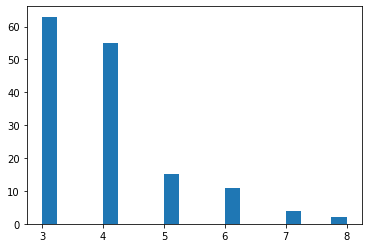

In [84]:
plt.hist(activities, bins = 20)

In [85]:
times = []
for i in white_filt:
    start = i[0]['start:timestamp']
    end = i[-1]['time:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    times.append(delta)
    mean = np.mean(times)
mean/60

131.50850815850816

(array([31., 22., 12.,  8., 10.,  8., 10., 11.,  6.,  9.,  1.,  4.,  6.,
         1.,  0.,  3.,  0.,  0.,  0.,  1.]),
 array([  133.  ,  1754.15,  3375.3 ,  4996.45,  6617.6 ,  8238.75,
         9859.9 , 11481.05, 13102.2 , 14723.35, 16344.5 , 17965.65,
        19586.8 , 21207.95, 22829.1 , 24450.25, 26071.4 , 27692.55,
        29313.7 , 30934.85, 32556.  ]),
 <BarContainer object of 20 artists>)

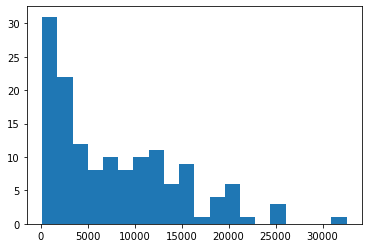

In [86]:
plt.hist(times, bins = 20)

In [87]:
7890/60

131.5

### Blue

In [88]:
pm4py.get_case_arrival_average(blue_log)/60

109.22336956521738

In [89]:
len(dataframe.Case.unique())

11457

In [90]:
blue_df = dataframe[dataframe.Triage_columns == 'BLUE']
print(blue_df['Name'].value_counts())
len(blue_df['Name'].value_counts())

DISCHARGE              1289
VISIT                  1289
AUTONOMOUSLY TRIAGE    1173
CONSULTATION            830
X-RAY REPORT            509
X-RAY                   504
EMERGENCY SERVICE       168
AMBULANCE TRIAGE        116
LABORATORY              103
ECHO                     49
TC                       22
TC REPORT                22
OBSERVATION               6
BLOOD SAMPLING            6
ANGIO REPORT              1
ANGIO                     1
Name: Name, dtype: int64


16

In [91]:
white_x = 0
for case in blue_df.Case.unique():
    if 'X-RAY' in blue_df[blue_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(blue_log)
white_x

498


0.38634600465477115

In [92]:
830/498

1.6666666666666667

In [93]:
blue_filt = pm4py.filter_end_activities(blue_log, 'DISCHARGE')
len(white_filt)

143

In [94]:
times = []
for i in blue_filt:
    start = i[0]['start:timestamp']
    end = i[-1]['time:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    times.append(delta)
    mean = np.mean(times)
mean/60

134.34879145587408

In [95]:
activities = []
for i in blue_log:
    activities.append(len(i))
mean = np.mean(activities)
mean

4.7230411171450735

### Green

In [96]:
pm4py.get_case_arrival_average(green_log)/60

21.798609387923907

In [97]:
green_df = dataframe[dataframe.Triage_columns == 'GREEN']
print(green_df['Name'].value_counts())
len(green_df['Name'].value_counts())

VISIT                  6449
DISCHARGE              6449
AUTONOMOUSLY TRIAGE    5030
CONSULTATION           4452
EMERGENCY SERVICE      2583
X-RAY REPORT           2529
X-RAY                  2514
LABORATORY             2358
AMBULANCE TRIAGE       1419
ECHO                    755
TC REPORT               432
TC                      431
BLOOD SAMPLING          373
OBSERVATION             111
ANGIO                    21
ANGIO REPORT             21
MRI REPORT                3
MRI                       3
Name: Name, dtype: int64


18

In [98]:
green_filt = pm4py.filter_end_activities(green_log, 'DISCHARGE')
len(green_filt)

5759

In [99]:
white_x = 0
for case in green_df.Case.unique():
    if 'X-RAY' in green_df[green_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(green_log)
white_x

2453


0.38036904946503336

In [100]:
white_x = 0
for case in green_df.Case.unique():
    if 'EMERGENCY SERVICE' in green_df[green_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(green_log)
white_x

1797


0.278647852380214

In [101]:
white_x = 0
for case in green_df.Case.unique():
    if 'CONSULTATION' in green_df[green_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(green_log)
white_x

3842


0.5957512792681036

In [102]:
2.6/1.8

1.4444444444444444

In [103]:
4452 / 3842

1.1587714731910463

In [104]:
activities = []
for i in green_log:
    activities.append(len(i))
mean = np.mean(activities)
mean

5.57187160800124

In [105]:
times = []
for i in green_filt:
    start = i[0]['start:timestamp']
    end = i[-1]['time:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    times.append(delta)
    mean = np.mean(times)
mean/60

162.00664177808648

In [106]:
times = []
for i in filtered_log:
    start = i[0]['start:timestamp']
    end = i[-1]['time:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    times.append(delta)
    mean = np.mean(times)
mean/60

188.43344534636756

### Yellow patients

In [107]:
pm4py.get_case_arrival_average(yellow_log)/60

42.09759908156135

In [108]:
yellow_df = dataframe[dataframe.Triage_columns == 'YELLOW']
print(yellow_df['Name'].value_counts())
len(yellow_df['Name'].value_counts())
pm4py.get_case_arrival_average(yellow_log)/60

EMERGENCY SERVICE      3858
LABORATORY             3758
VISIT                  3340
DISCHARGE              3340
AUTONOMOUSLY TRIAGE    1707
CONSULTATION           1689
X-RAY REPORT           1672
X-RAY                  1667
AMBULANCE TRIAGE       1633
BLOOD SAMPLING          930
TC                      685
TC REPORT               684
ECHO                    471
OBSERVATION             255
ANGIO                    74
ANGIO REPORT             74
MRI REPORT                2
MRI                       2
Name: Name, dtype: int64


42.09759908156135

In [109]:
yellow_filt = pm4py.filter_end_activities(yellow_log, 'DISCHARGE')
len(yellow_filt)

2791

In [110]:
white_x = 0
for case in yellow_df.Case.unique():
    if 'EMERGENCY SERVICE' in yellow_df[yellow_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(yellow_log)
white_x

1990


0.5958083832335329

In [111]:
white_x = 0
for case in yellow_df.Case.unique():
    if 'LABORATORY' in yellow_df[yellow_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(yellow_log)
white_x

2581


0.7727544910179641

In [112]:
white_x = 0
for case in yellow_df.Case.unique():
    if 'TC' in yellow_df[yellow_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(yellow_log)
white_x

666


0.19940119760479041

In [113]:
3850/1990

1.934673366834171

In [114]:
3758/2581

1.456024796590469

In [115]:
times = []
for i in yellow_filt:
    start = i[0]['start:timestamp']
    end = i[-1]['time:timestamp']
    delta = end - start
    delta = delta.total_seconds()
    times.append(delta)
    mean = np.mean(times)
mean/60

240.50371431983757

In [116]:
activities = []
for i in yellow_log:
    activities.append(len(i))
mean = np.mean(activities)
mean

7.7368263473053895

### Red

In [117]:
pm4py.get_case_arrival_average(red_log)/60

615.4494883040935

In [196]:
activities_red = {x:0 for x in dataframe.Name.unique()}
activities_yellow = {x:0 for x in dataframe.Name.unique()}
activities_green = {x:0 for x in dataframe.Name.unique()}
activities_blue = {x:0 for x in dataframe.Name.unique()}
activities_white = {x:0 for x in dataframe.Name.unique()}

In [203]:
activities_blue = {x:0 for x in dataframe.Name.unique()}
activities_white = {x:0 for x in dataframe.Name.unique()}

In [118]:
red_df = dataframe[dataframe.Triage_columns == 'RED']
print(red_df['Name'].value_counts())
len(red_df['Name'].value_counts())


EMERGENCY SERVICE      571
LABORATORY             277
DISCHARGE              229
VISIT                  229
AMBULANCE TRIAGE       199
CONSULTATION           173
X-RAY REPORT           111
X-RAY                  111
TC REPORT               98
TC                      97
ANGIO REPORT            33
ANGIO                   33
BLOOD SAMPLING          30
AUTONOMOUSLY TRIAGE     30
OBSERVATION             18
ECHO                     5
Name: Name, dtype: int64


16

In [188]:
len(dataframe.Case.unique())

11457

In [190]:
len(red_df.Case.unique())

229

In [192]:
len(red_log)

229

In [198]:
for case in yellow_df.Case.unique():
    for x in activities_yellow.keys():
        if x in yellow_df[yellow_df.Case == case]['Name'].value_counts():
            activities_yellow[x] += 1

{'AUTONOMOUSLY TRIAGE': 51.11,
 'VISIT': 100.0,
 'DISCHARGE': 100.0,
 'EMERGENCY SERVICE': 59.58,
 'LABORATORY': 77.28,
 'CONSULTATION': 43.32,
 'X-RAY': 47.57,
 'X-RAY REPORT': 47.57,
 'AMBULANCE TRIAGE': 48.89,
 'TC': 19.94,
 'TC REPORT': 19.94,
 'BLOOD SAMPLING': 27.84,
 'ANGIO': 2.22,
 'ANGIO REPORT': 2.22,
 'OBSERVATION': 7.63,
 'ECHO': 13.95,
 'MRI': 0.06,
 'MRI REPORT': 0.06}

In [ ]:
activities_yellow = {k:round((v*100/len(yellow_df.Case.unique())),2) for k,v in activities_yellow.items()}
activities_yellow

In [195]:
for case in red_df.Case.unique():
    for x in activities.keys():
        if x in red_df[red_df.Case == case]['Name'].value_counts():
            activities_red[x] += 1
activities_red = {k:round((v*100/len(red_log)),2) for k,v in activities_red.items()}
activities_red

{'AUTONOMOUSLY TRIAGE': 13.1,
 'VISIT': 100.0,
 'DISCHARGE': 100.0,
 'EMERGENCY SERVICE': 85.59,
 'LABORATORY': 90.39,
 'CONSULTATION': 52.84,
 'X-RAY': 47.6,
 'X-RAY REPORT': 47.6,
 'AMBULANCE TRIAGE': 86.9,
 'TC': 40.17,
 'TC REPORT': 40.17,
 'BLOOD SAMPLING': 13.1,
 'ANGIO': 14.41,
 'ANGIO REPORT': 14.41,
 'OBSERVATION': 7.86,
 'ECHO': 2.18,
 'MRI': 0.0,
 'MRI REPORT': 0.0}

In [204]:
for case in white_df.Case.unique():
    for x in activities.keys():
        if x in white_df[white_df.Case == case]['Name'].value_counts():
            activities_white[x] += 1
activities_white = {k:round((v*100/len(white_df.Case.unique())),2) for k,v in activities_white.items()}
activities_white

{'AUTONOMOUSLY TRIAGE': 92.67,
 'VISIT': 100.0,
 'DISCHARGE': 100.0,
 'EMERGENCY SERVICE': 9.33,
 'LABORATORY': 2.0,
 'CONSULTATION': 45.33,
 'X-RAY': 14.0,
 'X-RAY REPORT': 14.0,
 'AMBULANCE TRIAGE': 7.33,
 'TC': 0.67,
 'TC REPORT': 0.67,
 'BLOOD SAMPLING': 0.0,
 'ANGIO': 0.0,
 'ANGIO REPORT': 0.0,
 'OBSERVATION': 0.0,
 'ECHO': 0.67,
 'MRI': 0.0,
 'MRI REPORT': 0.0}

In [205]:
for case in blue_df.Case.unique():
    for x in activities.keys():
        if x in blue_df[blue_df.Case == case]['Name'].value_counts():
            activities_blue[x] += 1
activities_green = {k:round((v*100/len(blue_df.Case.unique())),2) for k,v in activities_green.items()}
activities_green

{'AUTONOMOUSLY TRIAGE': 91.0,
 'VISIT': 100.0,
 'DISCHARGE': 100.0,
 'EMERGENCY SERVICE': 10.01,
 'LABORATORY': 6.83,
 'CONSULTATION': 57.41,
 'X-RAY': 38.63,
 'X-RAY REPORT': 38.63,
 'AMBULANCE TRIAGE': 9.0,
 'TC': 1.71,
 'TC REPORT': 1.71,
 'BLOOD SAMPLING': 0.47,
 'ANGIO': 0.08,
 'ANGIO REPORT': 0.08,
 'OBSERVATION': 0.47,
 'ECHO': 3.8,
 'MRI': 0.0,
 'MRI REPORT': 0.0}

In [206]:
for case in green_df.Case.unique():
    for x in activities.keys():
        if x in green_df[green_df.Case == case]['Name'].value_counts():
            activities_green[x] += 1
activities_green = {k:round((v*100/len(green_df.Case.unique())),2) for k,v in activities_green.items()}
activities_green

{'AUTONOMOUSLY TRIAGE': 78.0,
 'VISIT': 100.0,
 'DISCHARGE': 100.0,
 'EMERGENCY SERVICE': 27.86,
 'LABORATORY': 29.26,
 'CONSULTATION': 59.58,
 'X-RAY': 38.04,
 'X-RAY REPORT': 38.04,
 'AMBULANCE TRIAGE': 22.0,
 'TC': 6.56,
 'TC REPORT': 6.56,
 'BLOOD SAMPLING': 5.78,
 'ANGIO': 0.33,
 'ANGIO REPORT': 0.33,
 'OBSERVATION': 1.72,
 'ECHO': 11.63,
 'MRI': 0.05,
 'MRI REPORT': 0.05}

In [120]:
196/229

0.8558951965065502

In [121]:
571/196

2.913265306122449

In [122]:
277/207

1.3381642512077294

In [123]:
white_x = 0
for case in red_df.Case.unique():
    if 'TC' in red_df[red_df.Case == case]['Name'].value_counts():
        white_x += 1
print(white_x)
white_x /= len(red_log)
white_x

92


0.4017467248908297

In [178]:
np.median(arrival_times)/60

7.333333333333333

In [124]:
activities = []
for i in red_log:
    activities.append(len(i))
mean = np.mean(activities)
mean

9.799126637554584

In [126]:
red_filt = pm4py.filter_end_activities(red_log, 'DISCHARGE')
len(red_filt)

131

In [151]:
times = []
for trace in filtered_log:
    for i in range(len(trace)-1):
        start = trace[i]['time:timestamp']
        end = trace[i+1]['start:timestamp']
        delta = end - start
        delta = delta.total_seconds()
        if delta > 0:
            times.append(delta)
mean = np.mean(times)
mean/60

26.387755224301372

In [147]:
log[0][0]

{'concept:name': 'AUTONOMOUSLY TRIAGE', 'triage color': 'BLUE', 'start:timestamp': datetime.datetime(2017, 1, 1, 0, 17, 51), 'time:timestamp': datetime.datetime(2017, 1, 1, 0, 17, 51), 'org:resource': 'autonomous', 'case:concept:name': '0'}

In [129]:
dict(dataframe.Name.value_counts())

{'DISCHARGE': 11457,
 'VISIT': 11457,
 'AUTONOMOUSLY TRIAGE': 8079,
 'CONSULTATION': 7222,
 'EMERGENCY SERVICE': 7196,
 'LABORATORY': 6499,
 'X-RAY REPORT': 4843,
 'X-RAY': 4818,
 'AMBULANCE TRIAGE': 3378,
 'BLOOD SAMPLING': 1339,
 'ECHO': 1281,
 'TC REPORT': 1237,
 'TC': 1236,
 'OBSERVATION': 390,
 'ANGIO': 129,
 'ANGIO REPORT': 129,
 'MRI REPORT': 5,
 'MRI': 5}

In [141]:
a = {k:round((v*10000/11457),0) for k,v in dict(dataframe.Name.value_counts()).items()}

In [142]:
a

{'DISCHARGE': 10000.0,
 'VISIT': 10000.0,
 'AUTONOMOUSLY TRIAGE': 7052.0,
 'CONSULTATION': 6304.0,
 'EMERGENCY SERVICE': 6281.0,
 'LABORATORY': 5673.0,
 'X-RAY REPORT': 4227.0,
 'X-RAY': 4205.0,
 'AMBULANCE TRIAGE': 2948.0,
 'BLOOD SAMPLING': 1169.0,
 'ECHO': 1118.0,
 'TC REPORT': 1080.0,
 'TC': 1079.0,
 'OBSERVATION': 340.0,
 'ANGIO': 113.0,
 'ANGIO REPORT': 113.0,
 'MRI REPORT': 4.0,
 'MRI': 4.0}

In [155]:
Cases = 10000
minutes = 12

In [169]:
(Cases * minutes)/60

2000.0

In [160]:
10000/60/24

6.944444444444444

In [176]:
import numpy.random as random

sum(random.exponential(scale=1/12, size=10000))

822.8649451425266

In [179]:
np.mean(arrival_times)/60

12.280001745810056

In [29]:
total_perc = {x:0 for x in activities}

In [30]:
for trace in filtered_log:
    temp = []
    for event in trace:
        temp.append(event['concept:name'])
    for activity in activities:
        if activity in temp:
            total_perc[activity] += 1
total_perc

{'VISIT': 11457,
 'DISCHARGE': 11457,
 'EMERGENCY SERVICE': 4126,
 'LABORATORY': 4766,
 'CONSULTATION': 6218,
 'X-RAY': 4670,
 'X-RAY REPORT': 4670,
 'TC': 1204,
 'TC REPORT': 1204,
 'BLOOD SAMPLING': 1339,
 'ANGIO': 129,
 'ANGIO REPORT': 129,
 'OBSERVATION': 390,
 'ECHO': 1271,
 'MRI': 5,
 'MRI REPORT': 5}

In [31]:
total_perc = {k:round((v*100/len(filtered_log)),2) for k,v in total_perc.items()}

In [32]:
total_perc

{'VISIT': 100.0,
 'DISCHARGE': 100.0,
 'EMERGENCY SERVICE': 36.01,
 'LABORATORY': 41.6,
 'CONSULTATION': 54.27,
 'X-RAY': 40.76,
 'X-RAY REPORT': 40.76,
 'TC': 10.51,
 'TC REPORT': 10.51,
 'BLOOD SAMPLING': 11.69,
 'ANGIO': 1.13,
 'ANGIO REPORT': 1.13,
 'OBSERVATION': 3.4,
 'ECHO': 11.09,
 'MRI': 0.04,
 'MRI REPORT': 0.04}

In [33]:
len(dataframe.Case.unique())

11457

In [34]:
dataframe.Name.value_counts()

VISIT                  11457
DISCHARGE              11457
AUTONOMOUSLY TRIAGE     8079
CONSULTATION            7222
EMERGENCY SERVICE       7196
LABORATORY              6499
X-RAY REPORT            4843
X-RAY                   4818
AMBULANCE TRIAGE        3378
BLOOD SAMPLING          1339
ECHO                    1281
TC REPORT               1237
TC                      1236
OBSERVATION              390
ANGIO REPORT             129
ANGIO                    129
MRI REPORT                 5
MRI                        5
Name: Name, dtype: int64

In [35]:
8079/11457

0.7051584184341451